# 2-An Evaluation of Annealing Algorithms

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenJij/OpenJijTutorial/blob/master/source/en/002-Evaluation.ipynb)

Annealing algorithms are heuristics, so it may not be able to give an optimal solution every time. These are algorithms for approximate solutions. In addition, these are probabilistic algorithm and solutions are also different each time. Therefore, when we evaluate them, we use various averages to evaluate these solution.

The three following indicators are often used.

- Success probability
- TTS : Time to solution
- Resudial energy

In particular, **TTS** is a measure of computation time and is often used in various evaluations. A Residual energy is an average value of how close to an optimal solution we got.

## Time to solution

An annealing algorithm can produce some kind of solution at any computation time. However even if the calculation is fast, it is useless if it gives wrong answers. We set an index (e.g., the time it takes to get the optimal solution with 90% probability) for the computation time it takes for the optimal solution to be calculated with the probability we need.

As shown in the previous chapter, an annealing algorithm looks for the optimal solution from among multiple runs, therefore multiple runs should be taken into account to evaluate the computation time.

A Time to Solution (TTS) is computed by taking into account the multiple annealing process.

We can easily lead TTS as follows.

One annealing time is defined as $\tau$. Let the probability of calculating the optimal solution in one annealing session be $p_s(\tau)$. $p_s(\tau)$ is the probability of success used to evaluate an algorithm.

From these definition, a failure probability that the optimal solution is not calculated in one annealing session is

$$1-p_s(\tau)$$

We repeat $R$ times. Then the probability that the optimal solution is not calculated in all these $R$ times is 

$$\{ 1-p_s(\tau) \}^R$$

Therefore the probability of obtaining the optimal solution at leaset once out of $R$ times $p_R$ is found to be

$$p_R = 1-\{ 1-p_s(\tau)\}^R$$

We solve this equation for $R$, and we get immediately

$$R = \frac{\ln(1-p_R)}{\ln\{1-p_s(\tau)\}}$$

To get the total computation time, we multiply the time per one annealing calculation by this formula.

$${\rm TTS}(\tau, p_R) = \tau R = \tau \frac{\ln(1-p_R)}{\ln\{1-p_s(\tau)\}}$$

This value means the total computation time for one annealing session, taking into account the computation time of $p_R$ and the number of iterations until the optimal solution is found with probability $p_s(p_R)$ when the algorithm with probability $p_s(\tau)$ is used to find the optimal solution.

In an evaluation of the actual computation, $p_R$ is given as a constant. The most common value used in research and other studies is $p_R = 0.99$. Then calculate $p_s(\tau)$ in various annealing time $\tau$. We use them to compute ${\rm TTS}(\tau, p_R)$.

### Measuring TTS with OpenJij

In this section, we measure TTS with OpenJij. In the following, We consider a one-dimensional antiferromagnetic Ising model. This is the physical model represented by the following Hamiltonian

$$H(\{\sigma_i\}) = \sum_{i=0}^{N-1} J_{i, i+1}\sigma_i \sigma_{i+1} + \sum_{i=0}^{N-1} h_i \sigma_i$$

where $J_{ij} \in [0.1, 1.0]$、$h_0 = -1$ respectively, and other longitudinal fields consider zero.

From antiferromagnetic condition, $J_{ij} > 0$, each spin faces a differenct direction and its energy is lowered. Therefore, optimal solution looks like $\{\sigma_i\}$は$1, -1, 1, -1, \cdots$. In addition, from $h_0=-1$ condition, we get the 0-th spin is $\sigma_0 = 1$. Finally, the optimal solution is $1, -1, 1, -1, \cdots$.

In short, the problem of "compute TTS of this problem" means total computation time it takes to obtain $1, -1, 1, \cdots$.

Let's solve the Ising model above and see how TTS chanegs as the time per calculation is extended.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

# import OpenJij
import openjij as oj 

In [2]:
# make one-dimensional antiferromagnetic Ising model
N = 30
h = {0: -10}
J = {(i, i+1): 1 for i in range(N-1)}

## Compute TTS

The response class returned by `sample_ising` or `sample_qubo` of openjij has member variable `info`. This is a dictionary of information for each sampler. Most sampler have an `execution_time` key, which is the execution time of each algorithm (in $\mu$s). 

In the case of SASampler, the computation time per one cycle of Simulated Annealing is stored.

In [3]:
# set optimal solution
correct_state = [(-1)**i for i in range(N)]

# define pR for TTS
pR = 0.99

# define num_sweeps_list, which is argument of Sampler 
# num_sweeps means the number of splits for decraesing parameters (temperature, transverse field) during annealing.
# therefore, the more we increase this parameter, the more slowly it is equivalent to annealing.

num_sweeps_list = list(range(10, 51, 10)) 

TTS_list = [] # define empty list for TTS of each computation
tau_list = [] # define empty list for computation time

# define empty list for success probability
ps_list = []

# set the number of times of annealing for computing probability
num_reads = 100

for num_sweeps in num_sweeps_list:
    sampler = oj.SASampler(num_sweeps=num_sweeps, num_reads=num_reads)  
    response = sampler.sample_ising(h, J)

    # get execution time of each annealing
    tau = response.info['execution_time']
    
    # get ps. 
    # state is ndarray, and we can compare this list with .all()
    ps = sum([1 if (state == correct_state).all() else 0 for state in response.states])/num_reads
    
    
    # When ps = 0, TTS diverges to infinity. We avoid this situation
    if ps == 0.0:
        continue
    
    # compute TTS
    TTS_list.append(np.log(1-pR)/np.log(1-ps)*tau)
    tau_list.append(tau)

    # compute success probability
    ps_list.append(ps)

Text(0, 0.5, 'Success probability')

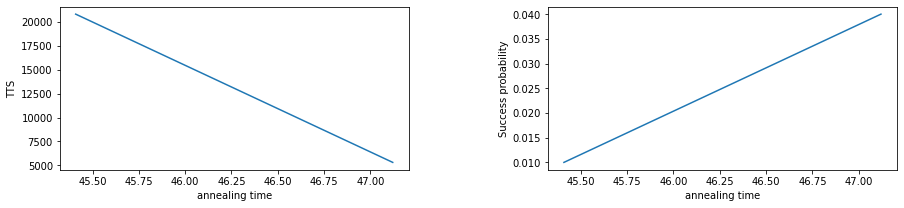

In [4]:
# this cell is for visualization of evaluation

# configure various settings
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(15,3))
plt.subplots_adjust(wspace=0.4)
fontsize = 10

# plot TTS
axL.plot(tau_list, TTS_list)
axL.set_xlabel('annealing time', fontsize=fontsize)
axL.set_ylabel('TTS', fontsize=fontsize)

# plot succss probability ps
axR.plot(tau_list, ps_list)
axR.set_xlabel('annealing time', fontsize=fontsize)
axR.set_ylabel('Success probability', fontsize=fontsize)

We showed you how to compute both TTS and success probability. Both of the two figures above, the horizontal axis is the coumputation time for one annealing session.

As the annealing time increases, TTS tends to increase as well. From this figure, we can use this value as an indicator of when we want to stop annealing once we have compensated for the required success probability.

OpenJij has TTS, Residual Energy and Success probability by default the benchmark function `openjij.solver_benchmark`.


## solver_benchmark function

solver_benchmark function compute TTS, residual energy and success probability, and return these values.

The arguments are listed below.

- solver: function  
    This function returns `Response` class. It needs arguments of `time` and `num_reads`
    `time` is parameter of computational time. In the case of `SASampler`, it corresponds to `num_sweeps`.
    `num_reads` specifies the number of times to sample to calculate TTS and residual energy.
    Also, the return value of the function `Response.info` contains the argument `time_name` as keyword.
    The value associated with `time_name` should be calculated time per cycle.
- time_list: list  
    a list of `time` argument of solver.
- solutions: list(list: state)  
    A list of states tha are the ground staet (optimal solution).
    In case of degenerate (multiple identical states that are indistinguishable from each other), 
    multiple state can be inserted, as in [state1, state2].
- args: dict
    Attach to the solver as an option, if required. The default is `args = {}`.
- p_r: 0 < float <= 1  
    This value is needed to compute TTS. It is equivalent to p_R.
- ref_energy: float  
    This means reference energy. Used in conjunction with measure_with_energy.
    The default is `ref_energy = 0`.
- measure_with_energy: bool  
    False: When the spin state matches the ground state, it counts as a success.
    True: If the energy is less than or equal to ref_energy, it counts as success.
    It is used when ground state is not known. The default is False.
- time_name: str  
    Specifies the key associated with the execution time of `Response.info`.
    The default is `'execution_time'`.
    
The return value is the result of the benchmark calculation and is stored in a dictionary format as shown below.

- time: A list of execution time.
- success_prob: A list of success probability.
- tts: A list of TTS.
- residual_energy: A list of residual energy.
- info: (dict) A parameter information of benchmark function.


Let us use this benchmark function to compute TTS and so on.

In [5]:
# define optimal solution
correct_state = [(-1)**i for i in range(N)]

# set num_sweeps & num_reads(the number of repetition)
num_sweeps_list = list(range(10, 51, 10))  # [10, 20, 30, 40, 50]
num_reads = 100

# compute TTS, residual energy, success probability with benchmark function
result = oj.solver_benchmark(
                      solver=lambda time, **args: oj.SASampler(num_sweeps=time, num_reads=num_reads).sample_ising(h,J), 
                      time_list=num_sweeps_list, solutions=[correct_state], p_r=0.99
            )

Text(0, 0.5, 'Success probability')

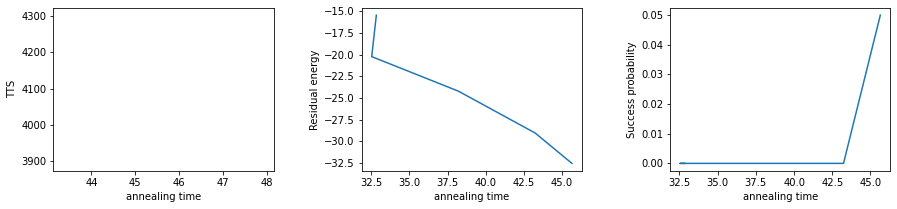

In [6]:
# configure the settings of drawing
fig, (axL,axC,axR) = plt.subplots(ncols=3, figsize=(15,3))
plt.subplots_adjust(wspace=0.4)
fontsize = 10

# plot TTS
axL.plot(result['time'], result['tts'])
axL.set_xlabel('annealing time', fontsize=fontsize)
axL.set_ylabel('TTS', fontsize=fontsize)

# plot residual energy
axC.plot(result['time'], result['residual_energy'])
axC.set_xlabel('annealing time', fontsize=fontsize)
axC.set_ylabel('Residual energy', fontsize=fontsize)

# plot of probability of appearance of optimal solution
axR.plot(result['time'], result['success_prob'])
axR.set_xlabel('annealing time', fontsize=fontsize)
axR.set_ylabel('Success probability', fontsize=fontsize)

We can easily benchmark with OpenJij.

Since the same antiferromagnetic 1D Ising model is used to solver the same problem as before, we can see that TTS and success probability are monotonically increasing, as in the previous example (because of heuristic solution, therefore exact calculation result changes every time).

The residual energy is expected to converge as some value if the annealing time increase.

We can set upt a free custom function if the function in `solver` returns the `Response` class and computation time is stored in `.info['execution_time']`.

The following is an example of creating and executing an appropriate user function. We can create a function that randomly returns one state from the three spin states of [1, 1, 1, 1,...], [1, -1, 1, -1,...] and [-1, 1, -1, 1,...], and benchmark the annealing algorithm. An Optimal solution is [1, -1, 1, -1,...].

In [7]:
import time 

def anti_ferro_solver(time_param, num_reads, h, J):
#    """
#    set function to choose randomly from three states
#    [1, 1, 1,...], [1,-1,1,...] & [-1,1,-1,...]
#    """
    
    # set subscript h & J
    indices = set(h.keys())
    indices = list(indices | set([key for keys in J.keys() for key in keys]))
    
    # make state of [1, 1, 1,...]
    ones_state = list(np.ones(len(indices), dtype=int))
    
    # make state of [-1, 1, -1,...]
    minus_plus_state = np.ones(len(indices), dtype=int)
    minus_plus_state[::2] *= -1
    
    # make state of [1, -1, 1,...]
    plus_minus_state = -1 * minus_plus_state
    
    # start measuring the execution time.
    start = time.time()
    _states = [ones_state, list(minus_plus_state), list(plus_minus_state)]
    
    # choose state randomly from three states
    state_record = [_states[np.random.randint(3)] for _ in range(num_reads)]
    # convert state_record to ndarray
    state_record = np.array(state_record)
    
    # Add the computation time at random
    exec_time = (time.time()-start) * 10**6 * time_param
    # compute energy at random
    energies = [sum(state) for state in state_record]
    
    # make tuple (state, subscript)
    samples_like = (state_record, indices)
        
    # we refer to from_samples (dimod) and store the state and energy in the Response class.
    response = oj.Response.from_samples(samples_like=samples_like, energy=energies, vartype='SPIN')
    # substitute computation time to response.info 'execution_time' key
    response.info['execution_time'] = exec_time
    
    return response

OpenJij's response is modeled after dimod's SampleSet.
Therefore, the advantage of being familiar with OpenJij is that it makes the transition to using dimod and D-Wave execution easier.  
Fom more details of dimod SampleSet, see also link below  
[Samples](https://docs.ocean.dwavesys.com/projects/dimod/en/latest/reference/sampleset.html)

In [8]:
# set optimal solution [1, -1, 1,...]
correct_state = [(-1)**i for i in range(N)]

# set num_sweeps & num_reads
num_sweeps_list = list(range(10, 51, 10))
num_reads = 2000

# compute TTS, residual energy & success probability with benchmark function
result = oj.solver_benchmark(
                      solver= lambda time_param, **args: anti_ferro_solver(time_param, num_reads, h, J), 
                      time_list=num_sweeps_list, solutions=[correct_state], p_r=0.99
              )

Text(0, 0.5, 'Success probability')

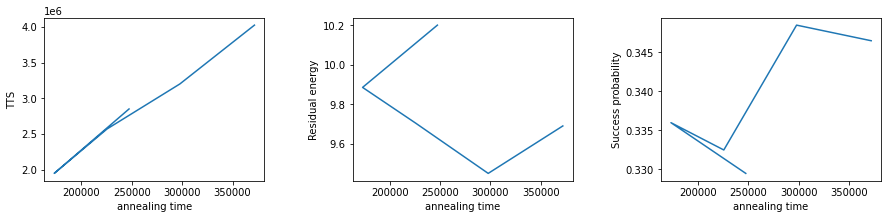

In [9]:
fig, (axL,axC,axR) = plt.subplots(ncols=3, figsize=(15,3))
plt.subplots_adjust(wspace=0.4)

fontsize = 10
axL.plot(result['time'], result['tts'])
axL.set_xlabel('annealing time', fontsize=fontsize)
axL.set_ylabel('TTS', fontsize=fontsize)

axC.plot(result['time'], result['residual_energy'])
axC.set_xlabel('annealing time', fontsize=fontsize)
axC.set_ylabel('Residual energy', fontsize=fontsize)

axR.plot(result['time'], result['success_prob'])
axR.set_xlabel('annealing time', fontsize=fontsize)
axR.set_ylabel('Success probability', fontsize=fontsize)

We randomly choose the optimal state for each one of the three states, so the probability of success shold be about 1/3. The above figure of success probability is also about 1/3 value.

With these solver functions in place, it is possible to compute TTS, residual energy and success probability, not just for OpenJij solvers.

Let us show you the ability to compute standard errors in the next page.